- Student name: Duy Hieu Nguyen
- SID: 33694052

# 4. **Logistic Regression versus Bayes Classifier**

## Task1: Initialize
Load the breast cancer dataset via load breast cancer in sklearn.datasets, import LogisticRegression from sklearn.linear model, and copy the code from Activity 3.3. for the Bayes classifier (BC). For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared). Perform a training/test split (with train size equal to 0.8) and report which of the models performs best in terms of train and test performance.

Load the dataset and necessary libraries:



In [22]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Load the dataset
data = load_breast_cancer()
x, y = data.data, data.target

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)


Bayesian Classifier Class


In [23]:
from scipy.stats import multivariate_normal

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

This function plots error for each models

c:\Users\chuth\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


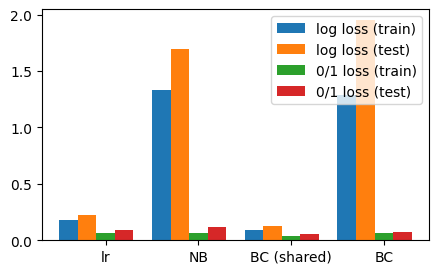

In [29]:
from matplotlib import pyplot as plt
from sklearn.metrics import zero_one_loss, log_loss

def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 + 3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

lr = LogisticRegression(solver='sag', max_iter=10000, tol=1e-4).fit(x_train, y_train) # tol is epsilon tolerance
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)

models = [lr, nb, bc_shared, bc]
model_names = ['lr', 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)
plt.legend()
plt.show()


### Comparison of Model Performance on Breast Cancer Dataset

- **Logistic Regression and Bayes Classifier (Shared Covariance)**: have the lowest training and testing error, showing that they are the best fit models.
- **Bayes Classifier and Naive Bayes (Unshared Covariance)**: exhibit higher error rates, indicating they might not be suited for this dataset.
- The superior performance of Logistic Regression and the Bayes Classifier with shared covariance implies that: the breast cancer dataset is probably **linearly separable** and different categories within the data may have **similar variability**.

## Task 2: Experiment for different size of data

Implement an experiment where you test the performance for increasing training sizes of N = 5, 10, . . . , 500. For each N sample 10 training sets of the corresponding size, fit all models, and record training and test errors. 

In [25]:
from sklearn.model_selection import train_test_split

# Initialize models
lr = LogisticRegression(solver='sag', max_iter=1000, tol=1e-3) #sag Stochastic Average Gradient descent
nb = BayesianClassifier(shared_cov=False, cond_ind=True)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False)
bc = BayesianClassifier(shared_cov=False, cond_ind=False)

models = [lr, nb, bc_shared, bc]
model_names = ['lr', 'nb', 'bcs', 'bc']

training_sizes = range(5, 505, 5)
all_errors = {name + "_train": [] for name in model_names}
all_errors.update({name + "_test": [] for name in model_names})

for N in training_sizes:
    train_errors_temp = {name: [] for name in model_names}
    test_errors_temp = {name: [] for name in model_names}
    
    for rep in range(10):
        # Split data
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=N, shuffle=True, random_state=rep)
        for i, model in enumerate(models):
            model.fit(x_train, y_train)
            # train_error = np.mean(y_train != model.predict(x_train))
            # test_error = np.mean(y_test != model.predict(x_test))
            test_error = zero_one_loss(y_test, model.predict(x_test))
            train_error = zero_one_loss(y_train, model.predict(x_train))
            
            train_errors_temp[model_names[i]].append(train_error)
            test_errors_temp[model_names[i]].append(test_error)
                
    # Compute average errors for this training size and append to results
    for name in model_names:
        all_errors[name + "_train"].append(np.mean(train_errors_temp[name]))
        all_errors[name + "_test"].append(np.mean(test_errors_temp[name]))

# The `all_errors` dictionary now contains average training and test errors for each model and each training size.


## Task 3: Plotting
Create suitable plots that compare the mean train and test performances of all models as a function of training size. There is no need to include error bars if that makes the plot too hard to read.


Plotting training and test error

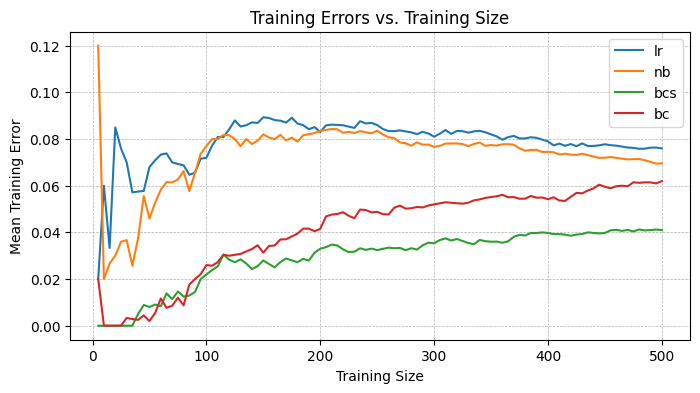

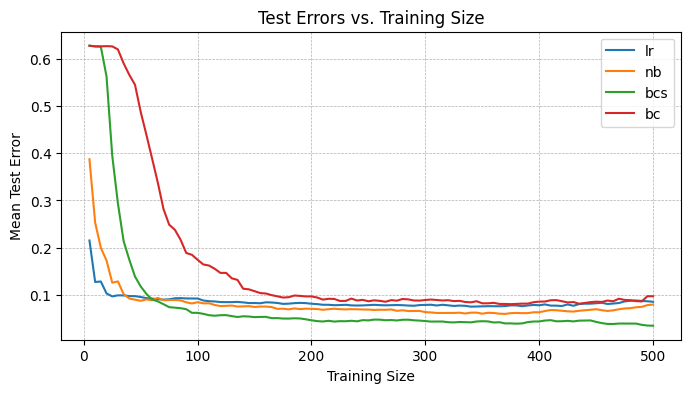

In [26]:
import matplotlib.pyplot as plt

# Training error plot
plt.figure(figsize=(8, 4))
for name in model_names:
    plt.plot(training_sizes, all_errors[name + "_train"], label=name)

plt.title("Training Errors vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("Mean Training Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Test error plot
plt.figure(figsize=(8, 4))
for name in model_names:
    plt.plot(training_sizes, all_errors[name + "_test"], label=name)

plt.title("Test Errors vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("Mean Test Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Task 4: Analyze

**a. What happens to each classifier's train and test performance when the number of training data points is increased?**

- **As $N$ increases**:
  - **Training Performance**:
    - For LR and NB, training error sharply jumps to 0.08 while that of BCS around 0.02 when $N \approx 100$, then they fluctuates steadily.
    - Specifically for the BC model, the training error gradually rises.
    - There is a significant fluctuation in the training error of LR.
    - **In general, tranning error increases**.
  - **Test Performance**:
    - Test errors for all models decline quickly as $N$ approaches 100. For the BC model, this decline continues until $N \approx 150$.
    - Notably, the BCS model's test error converges close to 0, indicating its strong generalization.
    - **In general, test error decreases**.
  - While training errors exhibit significant fluctuations, test errors appear more stable and smooth.
  
**b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?**

- **For Small $N$**: The LR model seems to perform better, with minimum errors ranging between 0.1 to 0.2.
- **For Large $N$**: The BCS model stands out, especially in test performance, with its error converging nearly to 0.

**c. Justify your observations by providing some speculations and possible reasons.**
- When $N$ is small, the models have a tendency to fit the data very closely, including its noise. This results in great performance on the training data but poor performance on test data, which is new, unseen data. (**Overfitting**)
- By increasing $N$, we add more data points, discourage models from fitting too closely to the training data as it could when $N$ small, result in:
  - The model doesn't fit the training data as perfectly, so ***training error goes up***.

  - But, the simpler model is better for new data, so ***test error goes down***.

- Test data which provides an average performance unseen dataset, is less influenced by the peculiarities of the training data. It leads to test error appears smoother than training error.

- The superior performance of Bayes Classifier with shared covariance implies that: the breast cancer dataset is probably **linearly separable** and different categories within the data may have **similar variability**. Meanwhile, unshared-(co)variance Naive Bayes and Bayes Classifier have unnecessary parameters for conditional (co)-variance to learn, which is likely to cause more error. 
- **Best performance model**:
  - LR works for small $N$ better because it's simple and can quickly find a linear boundary with fewer data points. BCS needs more data because it's complex and has many parameters to learn. 
  - When $N$ is high BCS can effectively learn from the data's complexity better. Meanwhile, LR, being simpler, might not capture all these intricate details



